# Предсказание рака груди с помощью логистической регрессии
- Построение модели логистической регрессии
- Подбор коэффициента регуляризации
- Интерпретация результатов

Датасет: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data#data.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.2)

plt.rcParams['figure.figsize'] = 16, 8

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve

#### Полезные функции для работы

In [2]:
def get_metrics(y_true, y_pred):
    quality = []
    metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
    print('=== Quality Report ===')
    for metric in metrics:
        current_metric_value = metric(y_true, y_pred)
        quality.append(current_metric_value)
        print(f'{metric.__name__.capitalize()}: {current_metric_value:.4f}')
    print('======================')
    return quality


def corr_feature_detect(data, threshold=0.85):
    corrmat = data.drop(['diagnosis'], axis=1).corr()
    corrmat = corrmat.abs().unstack().sort_values(ascending=False)
    corrmat = corrmat[corrmat >= threshold]
    corrmat = corrmat[corrmat < 1]
    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'corr']
    correlated_feats = []

    for row in corrmat.values:
        f1, f2, corr_value = row
        if not ((f1 in correlated_feats) | (f2 in correlated_feats)):
            f1_feat_len = corrmat[(corrmat.feature1==f1) | (corrmat.feature2==f1)].shape[0]
            f2_feat_len = corrmat[(corrmat.feature1==f2) | (corrmat.feature2==f2)].shape[0]

            if f1_feat_len >= f2_feat_len:
                correlated_feats.append(f1)
            else:
                correlated_feats.append(f2)
    
    return correlated_feats

#### План действий
1. Логистическая регрессия без настройки параметров
2. LogisticRegressionCV
3. Knn Grid search

In [3]:
df = pd.read_csv('data.csv')

In [4]:
print(f'Размер выборки: {df.shape}')
df.sample(10)

Размер выборки: (569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
361,901041,B,13.30,21.57,85.24,546.1,0.08582,0.06373,0.03344,0.02424,...,29.20,92.94,621.2,0.1140,0.1667,0.12120,0.05614,0.2637,0.06658,NaN
169,8712853,B,14.97,16.95,96.22,685.9,0.09855,0.07885,0.02602,0.03781,...,23.00,104.60,793.7,0.1216,0.1637,0.06648,0.08485,0.2404,0.06428,NaN
70,859575,M,18.94,21.31,123.60,1130.0,0.09009,0.10290,0.10800,0.07951,...,26.58,165.90,1866.0,0.1193,0.2336,0.26870,0.17890,0.2551,0.06589,NaN
17,84862001,M,16.13,20.68,108.10,798.8,0.11700,0.20220,0.17220,0.10280,...,31.48,136.80,1315.0,0.1789,0.4233,0.47840,0.20730,0.3706,0.11420,NaN
502,91505,B,12.54,16.32,81.25,476.3,0.11580,0.10850,0.05928,0.03279,...,21.40,86.67,552.0,0.1580,0.1751,0.18890,0.08411,0.3155,0.07538,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.40000,0.16250,0.2364,0.07678,NaN
479,911916,M,16.25,19.51,109.80,815.8,0.10260,0.18930,0.22360,0.09194,...,23.05,122.10,939.7,0.1377,0.4462,0.58970,0.17750,0.3318,0.09136,NaN
410,905502,B,11.36,17.57,72.49,399.8,0.08858,0.05313,0.02783,0.02100,...,36.32,85.07,521.3,0.1453,0.1622,0.18110,0.08698,0.2973,0.07745,NaN
497,914580,B,12.47,17.31,80.45,480.1,0.08928,0.07630,0.03609,0.02369,...,24.34,92.82,607.3,0.1276,0.2506,0.20280,0.10530,0.3035,0.07661,NaN
218,8811842,M,19.80,21.56,129.70,1230.0,0.09383,0.13060,0.12720,0.08691,...,28.64,170.30,2009.0,0.1353,0.3235,0.36170,0.18200,0.3070,0.08255,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

In [6]:
df.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

#### Удалим ненужные колонки

In [7]:
df = df.drop(['id', 'Unnamed: 32'], axis=1)

In [8]:
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


#### Распределение целевой переменной

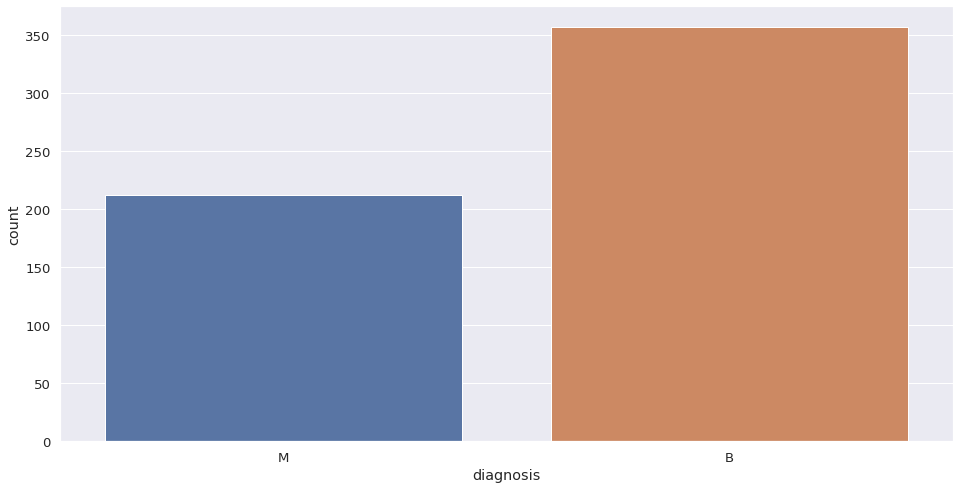

In [9]:
sns.countplot(x='diagnosis', data=df);

- **Корреляция некоторых признаков**

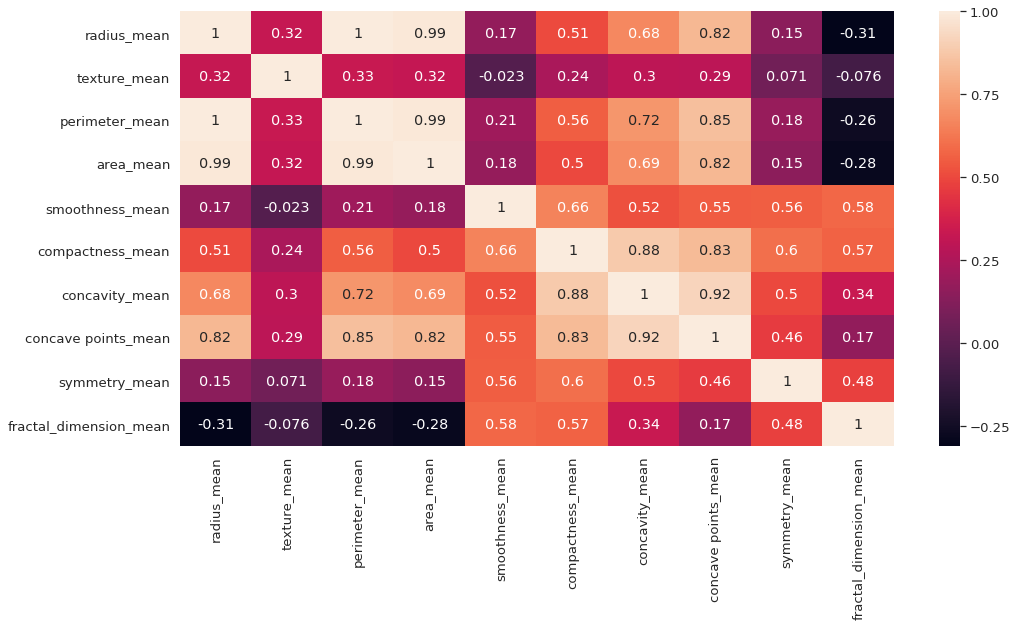

In [10]:
sns.heatmap(df.drop('diagnosis', axis=1).iloc[:, :10].corr(), annot=True);

#### Распределение признаков

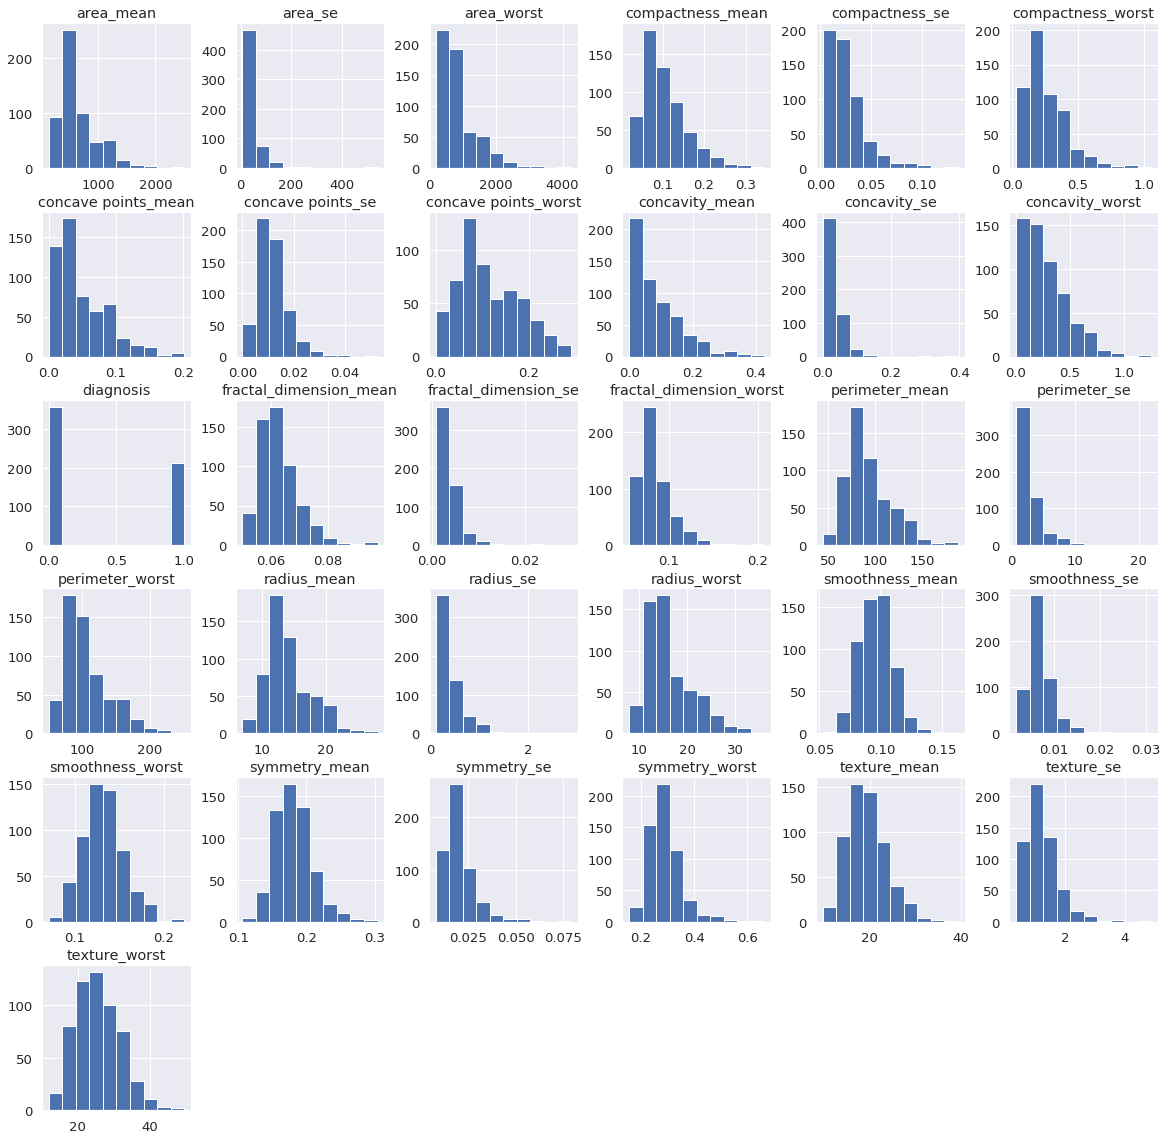

In [91]:
df.hist(figsize=[20, 20]);

#### Удалим признаки с корреляцией Пирсона больше 0.85

In [9]:
correlated_feats = corr_feature_detect(df)

In [10]:
print(correlated_feats)

['perimeter_mean', 'perimeter_worst', 'radius_mean', 'radius_worst', 'radius_se', 'area_worst', 'area_se', 'concavity_mean', 'texture_mean', 'concave points_mean', 'concavity_worst', 'compactness_worst']


#### На картинке:

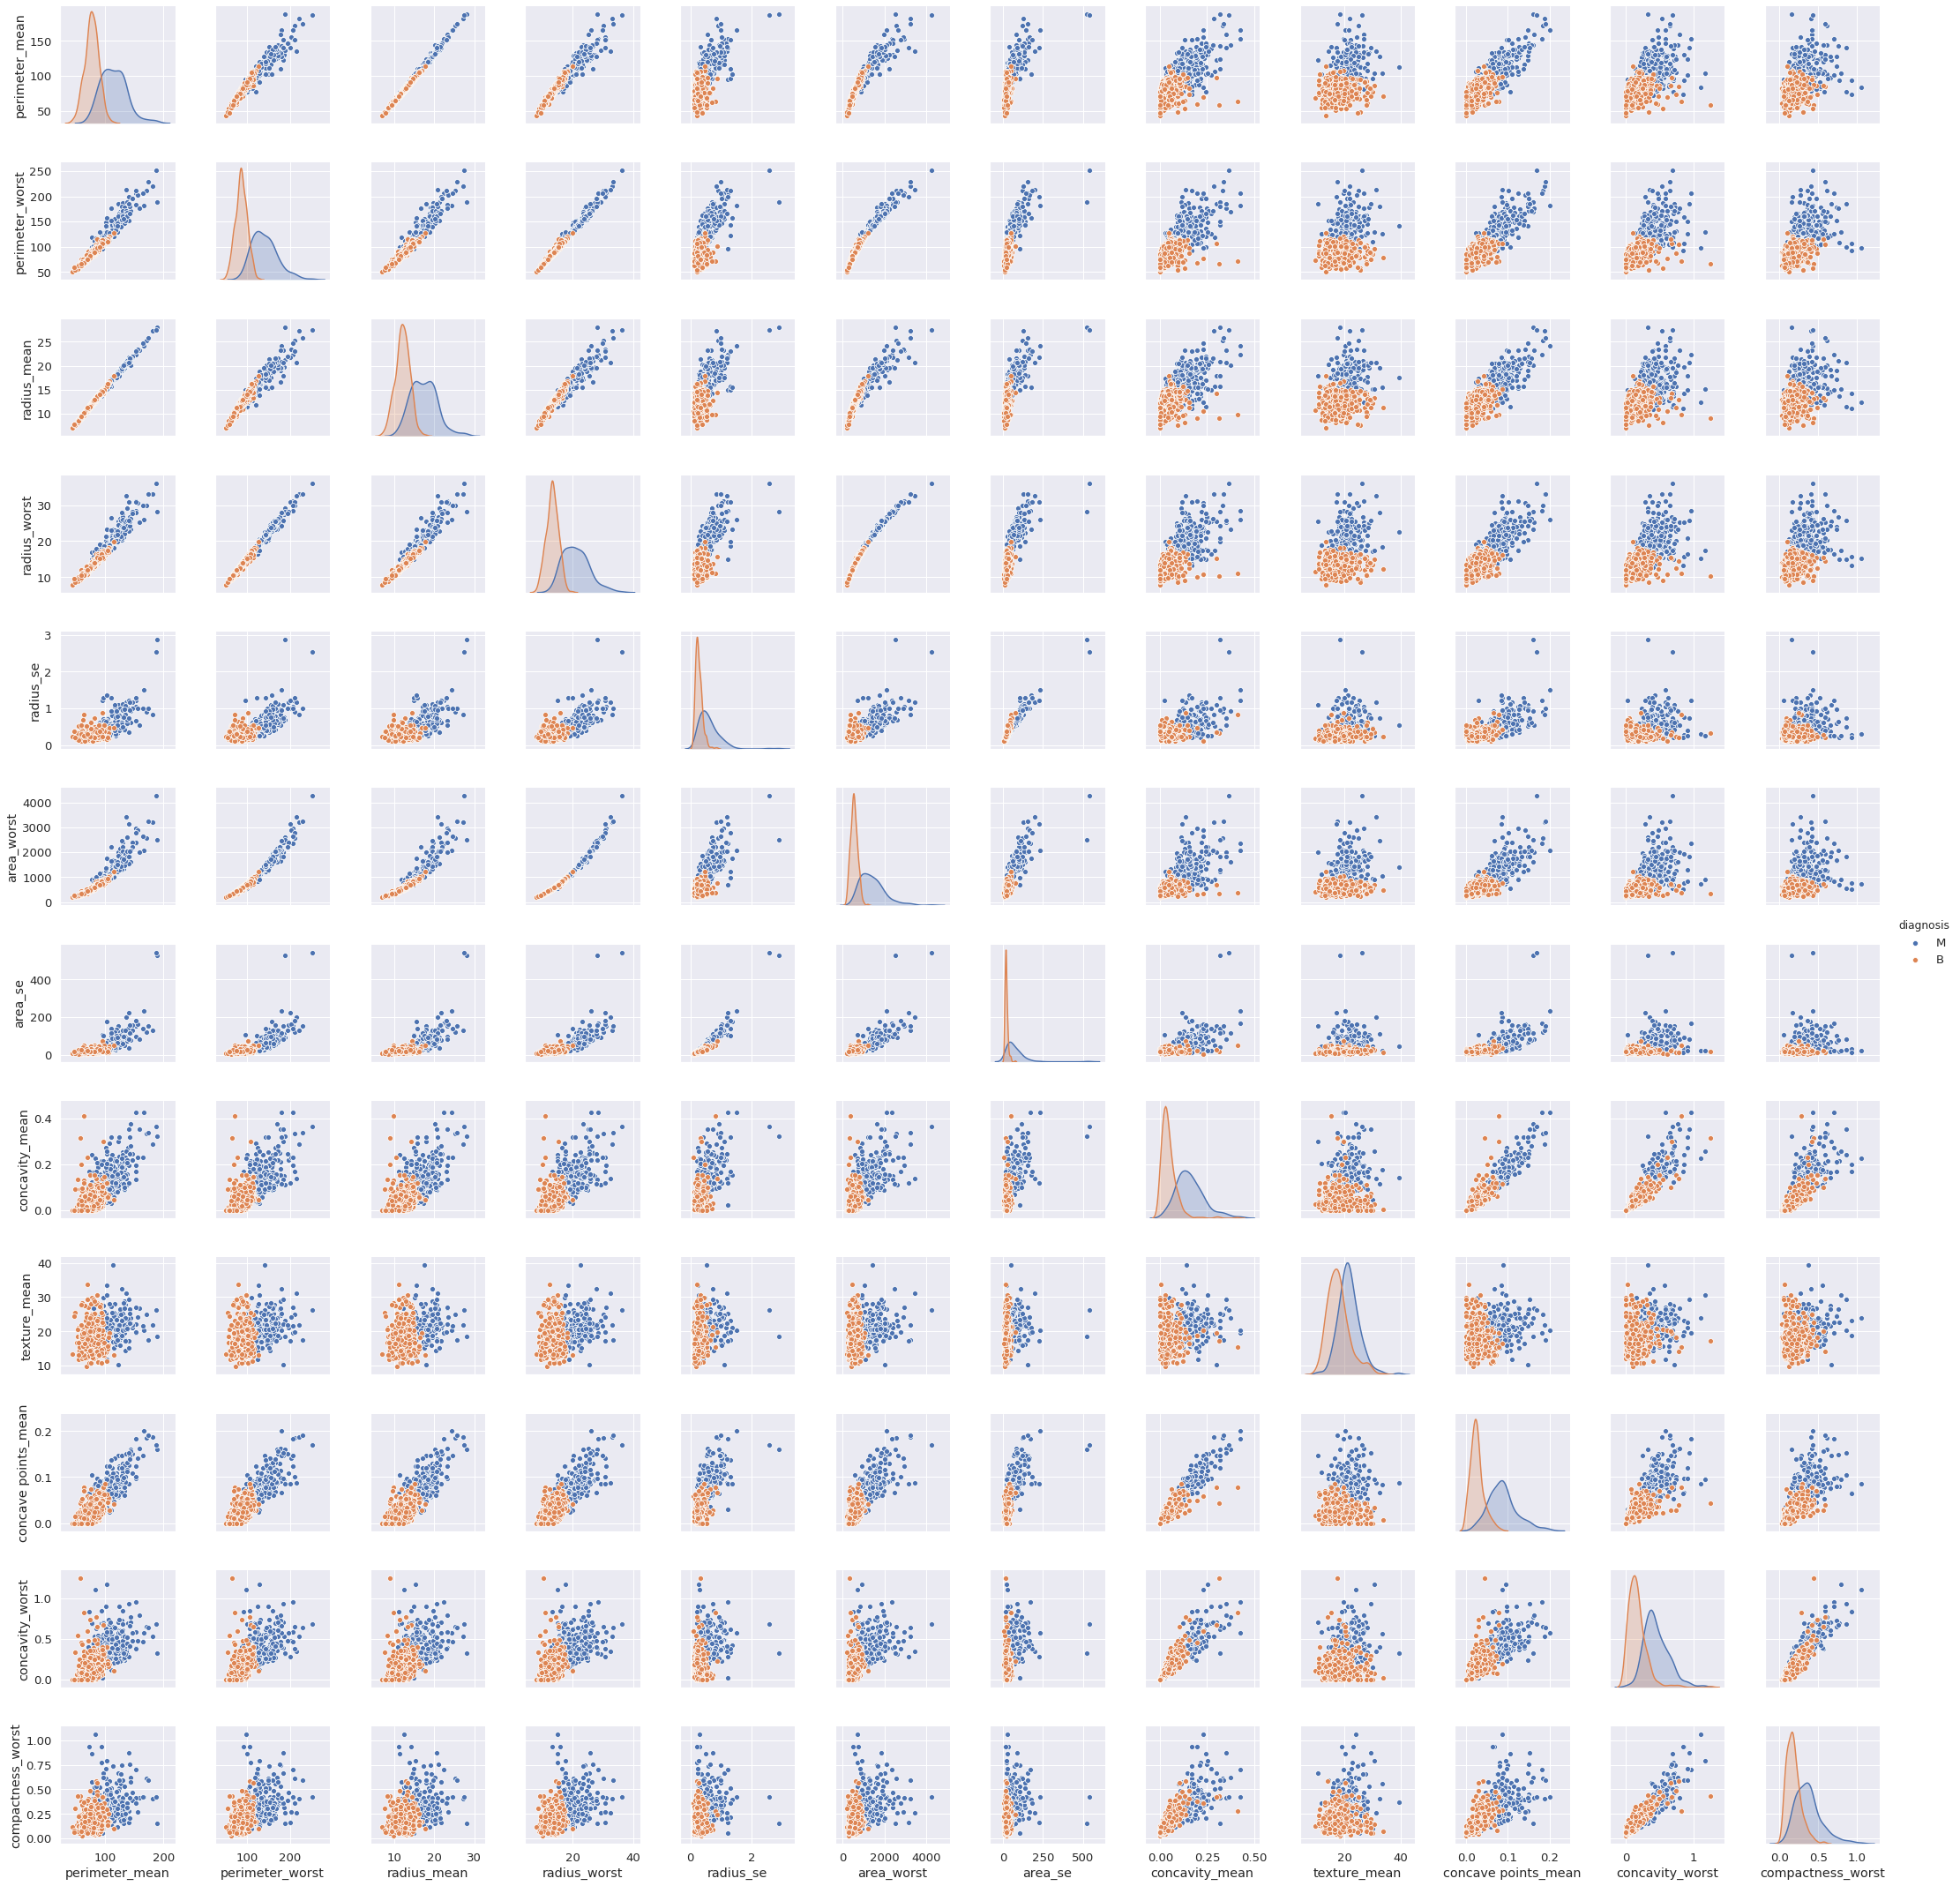

In [35]:
sns.pairplot(df[correlated_feats + ['diagnosis']], hue='diagnosis');

In [11]:
df = df.drop(correlated_feats, axis=1)

#### Подготовим категориальную переменную

In [12]:
df.diagnosis = df.diagnosis.apply(lambda x: 1 if x == 'M' else 0)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('diagnosis', axis=1), df.diagnosis, test_size=0.3, stratify=df['diagnosis']
)

#### Нормализация признаков

In [15]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Логистическая регрессия "из коробки" без настройки параметров

In [16]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
predict = model.predict(X_test)

In [18]:
columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
index = ['Log Regression из коробки']
df_quality = pd.DataFrame([get_metrics(y_test, predict)], columns=columns, index=index)

=== Quality Report ===
Accuracy_score: 0.9649
Precision_score: 0.9833
Recall_score: 0.9219
F1_score: 0.9516
Roc_auc_score: 0.9563


In [19]:
df_quality

,Accuracy,Precision,Recall,F1,ROC-AUC
Log Regression из коробки,0.964912,0.983333,0.921875,0.951613,0.956265


### LogisticRegressionCV

In [20]:
model = LogisticRegressionCV(Cs=100, n_jobs=-1)
model.fit(X_train, y_train)

LogisticRegressionCV(Cs=100, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [21]:
predict = model.predict(X_test)

In [22]:
df_quality.loc['LogisticRegressionCV', :] = get_metrics(y_test, predict)

=== Quality Report ===
Accuracy_score: 0.9708
Precision_score: 0.9836
Recall_score: 0.9375
F1_score: 0.9600
Roc_auc_score: 0.9641


In [23]:
df_quality

,Accuracy,Precision,Recall,F1,ROC-AUC
Log Regression из коробки,0.964912,0.983333,0.921875,0.951613,0.956265
LogisticRegressionCV,0.970760,0.983607,0.937500,0.960000,0.964077


#### Построим ROC кривую

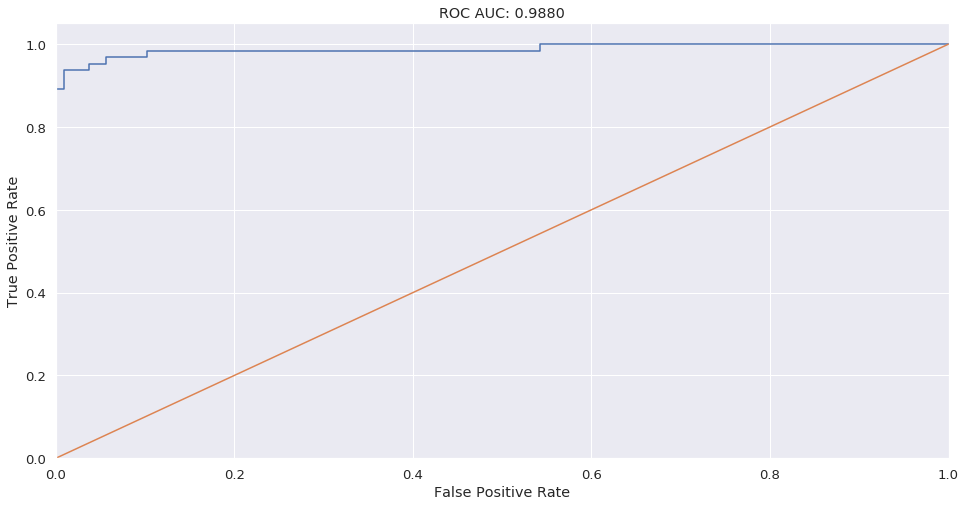

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC: {:.4f}'.format(auc_score))
plt.show()

#### Важность признаков

In [25]:
model.coef_.flatten()

array([ 2.11800743,  0.28301942,  0.28223313, -0.24180659, -0.72428321,
       -0.46392914,  1.61226305,  0.10753068, -0.27574331,  0.31841955,
        0.24578012, -0.40457397, -0.35682672,  1.45029296,  0.73679127,
        1.2403558 ,  0.88665742,  0.34154169])

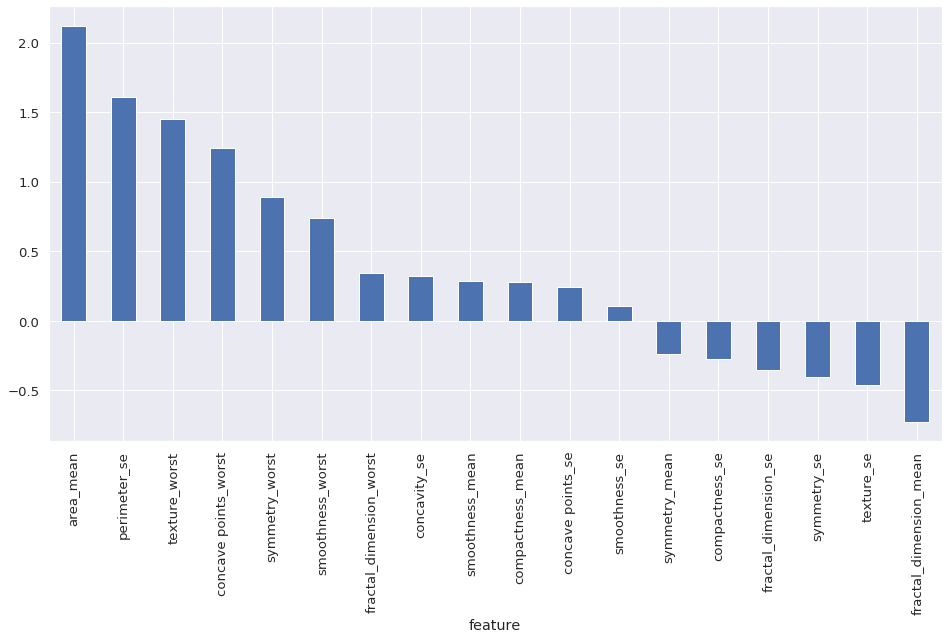

In [26]:
featureImportance = pd.DataFrame({"feature": df.drop('diagnosis',axis=1).columns, 
                                  "importance": model.coef_.flatten()})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot.bar();

#### Наиболее влияющие на рак признаки:
- area_mean
- perimeter_se
- texture_worst
- concave points_worst
- symmetry_worst
- smoothness_worst

[Описание признаков](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data#data.csv)

### KNN GridSearch

In [28]:
model = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1, 50)}

In [29]:
gridsearch = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)

In [30]:
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': range(1, 50)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [31]:
print(f'Best k: {gridsearch.best_params_["n_neighbors"]}')

Best k: 5


In [32]:
predict = gridsearch.predict(X_test)

In [34]:
df_quality.loc['KNN GridSearch', :] = get_metrics(y_test, predict)

=== Quality Report ===
Accuracy_score: 0.9532
Precision_score: 0.9667
Recall_score: 0.9062
F1_score: 0.9355
Roc_auc_score: 0.9438


### Итоговые метрики

In [35]:
df_quality

,Accuracy,Precision,Recall,F1,ROC-AUC
Log Regression из коробки,0.964912,0.983333,0.921875,0.951613,0.956265
LogisticRegressionCV,0.970760,0.983607,0.937500,0.960000,0.964077
KNN GridSearch,0.953216,0.966667,0.906250,0.935484,0.943779


#### И с небольшим отрывом побеждает LogisticRegressionCV со значениями по умолчанию! 🥳